In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)


# Data Load

In [2]:
train = pd.read_csv("./dataset/train.csv", parse_dates=['datetime'])
test  = pd.read_csv("./dataset/test.csv" , parse_dates=['datetime'])
submit = pd.read_csv("./dataset/sampleSubmission.csv")

In [3]:
print(train.shape)
print(train.info())
train.head(2)

(10886, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [4]:
print(test.shape)
print(test.info())
test.head(2)

(6493, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB
None


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000


## train에만 있는 피쳐 삭제
* test는 타겟피쳐가 없기 때문에 train - 1개 피쳐를 갖는다

## train_test 합치기

In [5]:
train = train.drop(['casual', 'registered'], axis=1)
train.shape, test.shape

((10886, 10), (6493, 9))

In [6]:
train_test = pd.concat([train, test], axis=0)
train_test.shape

(17379, 10)

In [7]:
train_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1.0


## train_test 분리

In [8]:
# train = train_test.iloc[:10886]
# test = train_test.iloc[10886:]
# test = test.drop(['count'], axis=1)
# train.shape, test.shape


In [9]:
# for df in  [train, test]:
#     df = df.rename(columns={"datetime":"regtime"})
    
#     df['PC_y'] = df['regtime'].dt.year
#     df['PC_m'] = df['regtime'].dt.month
#     df['PC_d'] = df['regtime'].dt.day
#     df['PC_h'] = df['regtime'].dt.hour
#     df['PC_w'] = df['regtime'].dt.dayofweek  #0:월~6:일

In [10]:
train_test = train_test.rename(columns={"datetime":"regtime"})

In [11]:
train_test.head()

,regtime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1.0


In [12]:
train_test['PC_y'] = train_test['regtime'].dt.year
train_test['PC_m'] = train_test['regtime'].dt.month
train_test['PC_d'] = train_test['regtime'].dt.day
train_test['PC_h'] = train_test['regtime'].dt.hour
train_test['PC_w'] = train_test['regtime'].dt.dayofweek  #0:월~6:일
train_test.tail(2)  #2011-01-01 00:00:00  --> 2011	1	1	0	5(토)
              #2012-12-19 23:00:00  --> 2012	12	19	22	2(수)

,regtime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,PC_y,PC_m,PC_d,PC_h,PC_w
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,2012,12,31,22,0
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,2012,12,31,23,0


* 피쳐 --> index로 집어넣기

In [13]:
train_test = train_test.set_index('regtime')
train_test.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,PC_y,PC_m,PC_d,PC_h,PC_w
regtime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16.0,2011,1,1,0,5
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40.0,2011,1,1,1,5


* index --> 피쳐로 꺼내기

In [14]:
# train_test = train_test.reset_index() #inplace=False,
# train_test.head()

# 우선 점수보기
* 결측없다
* object 없다

In [15]:
train = train_test.iloc[:10886]
test = train_test.iloc[10886:]
test = test.drop(['count'], axis=1)

#----------------------------------------------- 하단 코드 동일
y = train['count']
X = train.drop(['count'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=1234)
model = RandomForestRegressor(random_state=0, n_estimators=100)

model.fit(X_train, y_train)
pred = model.predict(X_val)
rmse = mean_squared_error(y_val, pred, squared=False)
rmsle = mean_squared_log_error(y_val, pred, squared=False)
print(f"RMSLE:{rmsle:.4f} MSLE:{rmse:.4f} {model.__class__.__name__}")  # np.sqrt(mean_squared_log_error())


RMSLE:0.3386 MSLE:38.2739 RandomForestRegressor


In [58]:
def my_fit_score(train_test, model=None, make_submit=None):
    train = train_test.iloc[:10886]
    test = train_test.iloc[10886:]
    test = test.drop(['count'], axis=1)

    #----------------------------------------------- 하단 코드 동일
    y = train['count']
    X = train.drop(['count'], axis=1)

    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=1234)
    if model == None:
        model = RandomForestRegressor(random_state=0, n_estimators=100)

    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred, squared=False)
    rmsle = mean_squared_log_error(y_val, pred, squared=False)
    print(f"RMSLE:{rmsle:.4f} MSLE:{rmse:.4f} {model.__class__.__name__}")  # np.sqrt(mean_squared_log_error())
    
    
    
    if make_submit != None:
        #------------------------------------------------- 답안지 작성
        submit['count'] = test_pred.reshape(-1,1)
        print(submit.head(2))
        submit.to_csv("v01.csv", index=False)             # top33% 0.421??

    

# submit 제출 방법

In [17]:
#------------------------------------------------- 공모전 제출용 학습
test_pred = model.predict(test)        #---------->  submit 제출 답안
test_pred = np.round(test_pred, 0).astype(int)

#------------------------------------------------- 제출 전 확인
print(len(test_pred), test_pred)
print(submit['datetime'].min(), submit['datetime'].max())
print(test.index.values.min()   , test.index.values.max())
submit.head(1)
#------------------------------------------------- 답안지 작성
submit['count'] = test_pred.reshape(-1,1)
print(submit.head(2))
submit.to_csv("v01.csv", index=False)             # top33% 0.421??

6493 [ 13   6   6 ... 147 109  66]
2011-01-20 00:00:00 2012-12-31 23:00:00
2011-01-20T00:00:00.000000000 2012-12-31T23:00:00.000000000
              datetime  count
0  2011-01-20 00:00:00     13
1  2011-01-20 01:00:00      6


#top33% 0.421??

# EDA
* ref : https://seaborn.pydata.org/generated/seaborn.countplot.html
* ref : https://seaborn.pydata.org/generated/seaborn.barplot.html
* linechart : PC~관련피쳐
* barchart
* boxplot

## train test 분포도

In [18]:
print(train.columns.tolist())

['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'PC_y', 'PC_m', 'PC_d', 'PC_h', 'PC_w']


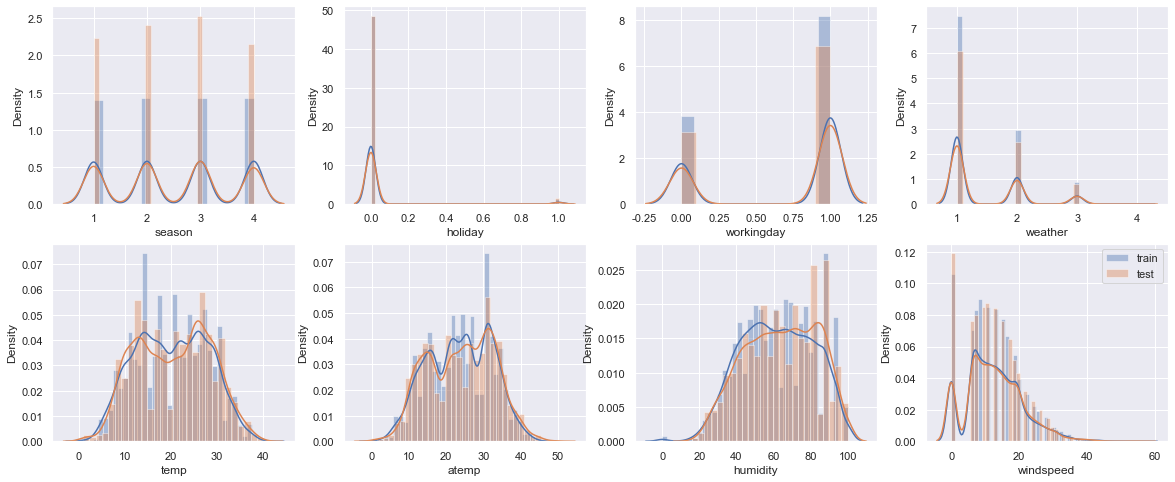

In [19]:
p, axes = plt.subplots(2,4, figsize=(20,8))
col_list = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
for i, col in enumerate(col_list):
    r = i//4
    c = i%4
    sns.distplot(train[col], label="train", ax=axes[r][c])
    sns.distplot(test[col], label="test",  ax=axes[r][c])
plt.legend()
plt.show()

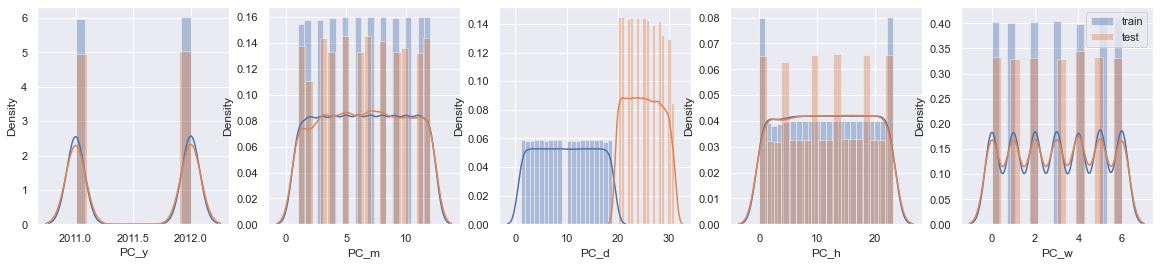

In [20]:
p, axes = plt.subplots(1,5, figsize=(20,4))
col_list = ['PC_y', 'PC_m', 'PC_d', 'PC_h', 'PC_w']
for i, col in enumerate(col_list):
    sns.distplot(train[col], label="train", ax=axes[i])
    sns.distplot(test[col], label="test",  ax=axes[i])
plt.legend()
plt.show()

<AxesSubplot:xlabel='PC_d', ylabel='count'>

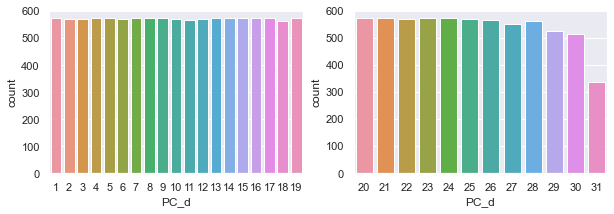

In [21]:
p, axes = plt.subplots(1,2, figsize=(10,3))
sns.countplot(train["PC_d"], ax=axes[0])
sns.countplot(test["PC_d"], ax=axes[1])

In [22]:
print(test.shape,   test[test["PC_d"]>=29]["PC_d"].shape[0] , test[test["PC_d"]>=29]["PC_d"].shape[0]/test.shape[0])
test[test["PC_d"]>=29]["PC_d"].value_counts()

(6493, 13) 1376 0.2119205298013245


29    526
30    514
31    336
Name: PC_d, dtype: int64

* PC_d : train(1 ~ 20) , test(20 ~ 31)
* 학습에서 제외

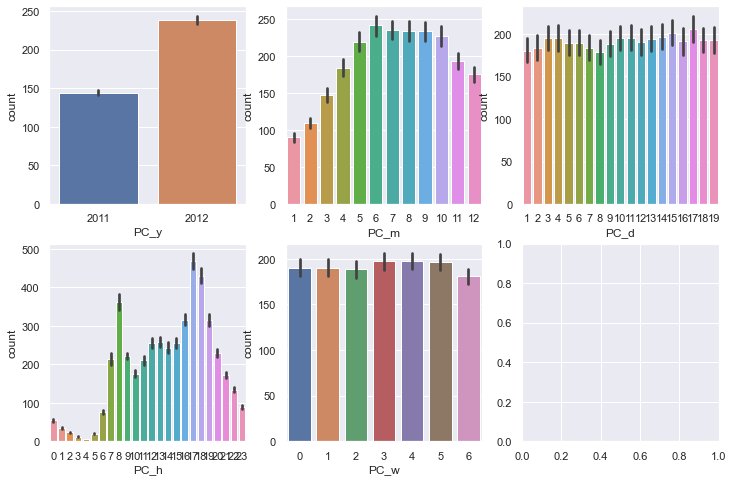

In [23]:
p, axes = plt.subplots(2,3, figsize=(12,8))
sns.barplot(train["PC_y"], train["count"], ax=axes[0][0])
sns.barplot(train["PC_m"], train["count"], ax=axes[0][1])
sns.barplot(train["PC_d"], train["count"], ax=axes[0][2])
sns.barplot(train["PC_h"], train["count"], ax=axes[1][0])
sns.barplot(train["PC_w"], train["count"], ax=axes[1][1])
plt.show()

* 주말 ~ 평일 : 차이 무의미하다
* 날씨 : 5월 ~ 10월
* 시간 : 7 ~ 9시 , 17 ~ 18시  --> 출퇴근,통학용 주로 이용될 듯 하다.

<pre>  
평일/휴일
    'holiday', 'workingday' 

계절
    'season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed'

In [24]:
train[['holiday', 'workingday', 'PC_w']].value_counts()

holiday  workingday  PC_w
0        0           5       1584
                     6       1579
         1           3       1553
                     1       1539
                     2       1527
                     4       1481
                     0       1312
1        0           0        239
                     4         48
                     2         24
dtype: int64

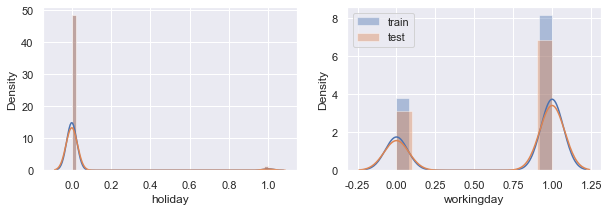

In [25]:
p, axes = plt.subplots(1,2, figsize=(10,3))
col_list = ['holiday', 'workingday']
for i, col in enumerate(col_list):
    sns.distplot(train[col], label="train", ax=axes[i])
    sns.distplot(test[col], label="test",  ax=axes[i])
plt.legend()
plt.show()

* season ,  PC_m : 다중공선 확인 필요

In [26]:
train[['season', 'PC_m']].value_counts().sort_index()

season  PC_m
1       1       884
        2       901
        3       901
2       4       909
        5       912
        6       912
3       7       912
        8       912
        9       909
4       10      911
        11      911
        12      912
dtype: int64

*  'weather', 'temp', 'atemp', 'humidity', 'windspeed'

In [27]:
train[['weather', 'temp', 'atemp', 'humidity', 'windspeed']].head()

,weather,temp,atemp,humidity,windspeed
regtime,,,,,
2011-01-01 00:00:00,1,9.84,14.395,81,0.0
2011-01-01 01:00:00,1,9.02,13.635,80,0.0
2011-01-01 02:00:00,1,9.02,13.635,80,0.0
2011-01-01 03:00:00,1,9.84,14.395,75,0.0
2011-01-01 04:00:00,1,9.84,14.395,75,0.0


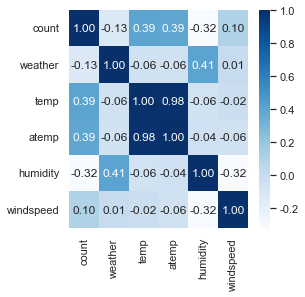

In [28]:
plt.figure(figsize=(4,4))
sns.heatmap(train[['count','weather', 'temp', 'atemp', 'humidity', 'windspeed']].corr(), annot=True, fmt=".2f", cmap="Blues")
plt.show()

<pre>
* temp    - atemp     : 다중공선                 --> 피쳐 drop
* weather - count     : -0.13 별 관계가 없다      --> weather 4 아웃라이어 처리 안함
* weather - windspeed :  0.10 아무 관계도 아니다  --> 0 데이터 처리 

* weather - humidity  :  0.41 약한 상관관계

In [29]:
train['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

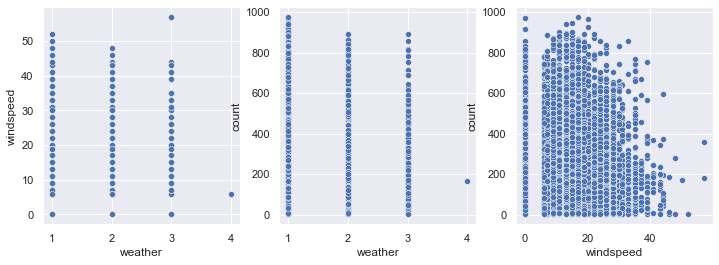

In [30]:
p, axes = plt.subplots(1,3, figsize=(12,4))
sns.scatterplot(x=train['weather'], y=train['windspeed'], ax=axes[0])
sns.scatterplot(x=train['weather'], y=train['count'], ax=axes[1])
sns.scatterplot(x=train['windspeed'], y=train['count'], ax=axes[2])
plt.show()

### 불필요 컬럼 삭제

In [31]:
train_test = train_test.drop(['temp','PC_d'], axis=1)

In [32]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   holiday     17379 non-null  int64  
 2   workingday  17379 non-null  int64  
 3   weather     17379 non-null  int64  
 4   atemp       17379 non-null  float64
 5   humidity    17379 non-null  int64  
 6   windspeed   17379 non-null  float64
 7   count       10886 non-null  float64
 8   PC_y        17379 non-null  int64  
 9   PC_m        17379 non-null  int64  
 10  PC_h        17379 non-null  int64  
 11  PC_w        17379 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.7 MB


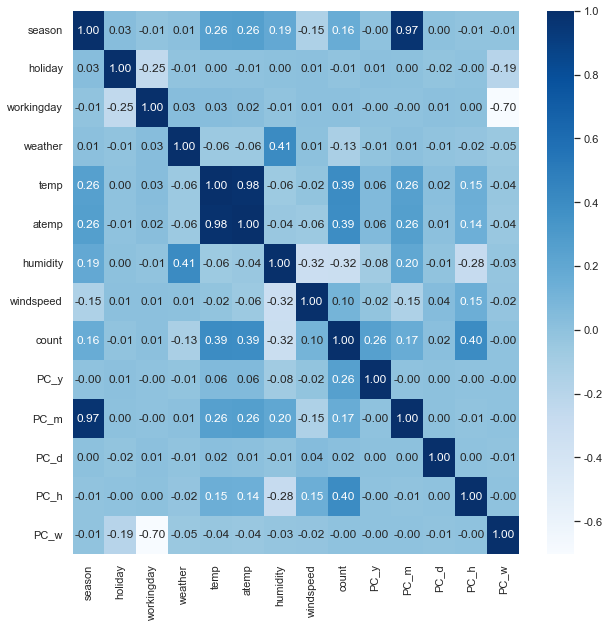

In [33]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap="Blues")
plt.show()

### 삭제 피쳐

* season  - PC_m : 다중공선 --> 학습 후 결정


In [34]:
my_fit_score(train_test, model=None)

RMSLE:0.3352 MSLE:38.4568 RandomForestRegressor


* 다중공선이 걸리더라도 RF모델에서는 점수가 다소 좋아진다. 
* PC_m 삭제 보류

In [35]:
train_test1 = train_test.copy()
train_test1 = train_test1.drop('PC_m', axis=1)
my_fit_score(train_test1, model=None)

RMSLE:0.3438 MSLE:41.5261 RandomForestRegressor


In [36]:
del train_test1

# 본격적 가공

## windspeed
* weather - count     : -0.13 별 관계가 없다
* weather - windspeed :  0.10 아무 관계도 아니다

In [37]:
train_test['windspeed'].value_counts()

0.0000     2180
8.9981     1738
11.0014    1695
12.9980    1657
7.0015     1617
15.0013    1513
6.0032     1425
16.9979    1295
19.0012    1048
19.9995     808
22.0028     602
23.9994     460
26.0027     381
27.9993     296
30.0026     176
31.0009     146
32.9975     112
35.0008      84
39.0007      44
36.9974      39
40.9973      23
43.0006      14
43.9989      11
46.0022       5
50.0021       2
56.9969       2
47.9988       2
54.0020       2
51.9987       1
55.9986       1
Name: windspeed, dtype: int64

In [38]:
train_test[train_test['windspeed'] == .0].shape, train_test[train_test['windspeed'] == .0].shape[0]/train_test.shape[0]

((2180, 12), 0.12543874791414927)

In [39]:
#  train[~train['windspeed'] == .0].shape
train_test[train_test['windspeed'] != .0].shape,     train_test[train_test['windspeed'] != .0].shape[0]/train_test.shape[0]

((15199, 12), 0.8745612520858508)

In [40]:
train_test[train_test['windspeed'] != .0].head(2)

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,PC_y,PC_m,PC_h,PC_w
regtime,,,,,,,,,,,,
2011-01-01 05:00:00,1,0,0,2,12.880,75,6.0032,1.0,2011,1,5,5
2011-01-01 10:00:00,1,0,0,1,19.695,76,16.9979,36.0,2011,1,10,5


In [41]:
# KNN, RFR ... 

col_list = ['season', 'weather', 'atemp', 'humidity', 'PC_y', 'PC_m', 'PC_h']

windspped_X_train = train_test[train_test['windspeed'] != .0][col_list]        #--9573 .. ~windspped
windspped_y_train = train_test[train_test['windspeed'] != .0]['windspeed']     #--9573 ..  windspped
windspped_X_test  = train_test[train_test['windspeed'] == .0][col_list] 
# windspped_y_test  = pred
print(windspped_y_train.shape, windspped_X_train.shape)
windspped_X_train.head()

windspped_model = RandomForestRegressor(n_estimators=100, random_state=1234)
windspped_model.fit(windspped_X_train, windspped_y_train)
windspped_pred = windspped_model.predict(windspped_X_test)           #--1313문제
print(windspped_pred[:5],  windspped_pred.shape)                     #--1313 예측답안갯수

#--1313건에 해당하는 0값을 windspped값을 pred    -->   windspped_y_test로 대체
#windspped_y_test['windspped']  = pred.reshape(-1,1)

# train[train['col']>0] = 5                    #error
train_test.loc[train_test['windspeed'] == .0 , 'windspeed'] = windspped_pred.reshape(-1,1)

(15199,) (15199, 7)
[10.2711     9.840558  10.020118   8.3064925  7.2070225] (2180,)


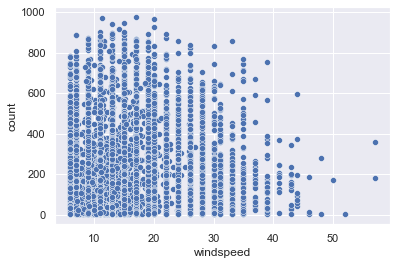

In [42]:
sns.scatterplot(x=train_test.iloc[:train.shape[0]]['windspeed'], y=train.iloc[:train.shape[0]]['count'])
plt.show()

In [43]:
my_fit_score(train_test, model=None)    #0.33756

RMSLE:0.3359 MSLE:38.7450 RandomForestRegressor


## 스케일링
* traget 피쳐 - 로그변환
* 정규화
* 왜도/첨도

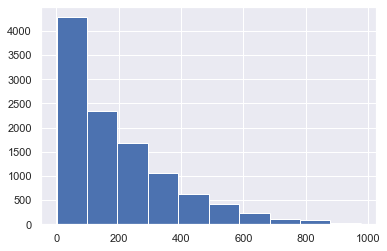

In [44]:
train_test.iloc[:train.shape[0]]['count'].hist()
train_test.iloc[:train.shape[0]]['count'] = np.log1p(  train_test.iloc[:train.shape[0]]['count']  )

<AxesSubplot:>

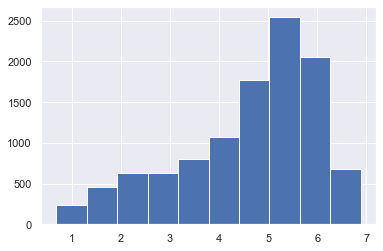

In [45]:
train_test.iloc[:train.shape[0]]['count'].hist()

In [46]:
my_fit_score(train_test, model=None)    #0.33756

RMSLE:0.0853 MSLE:0.3055 RandomForestRegressor


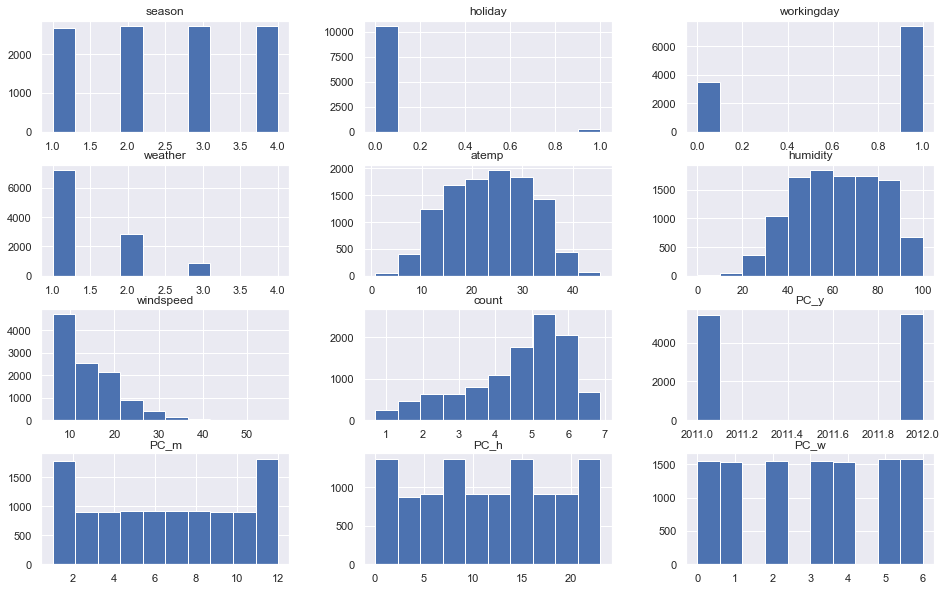

In [47]:
train_test.iloc[:train.shape[0]].hist(figsize=(16,10))
plt.show()

* 범주형(categrory) : get_dummy(), OneHotEncoder()
* 연속형 : 정규분포-스케일링,  왜도/첨도-log변환

In [48]:
train_test['windspeed'] = np.log1p(train_test['windspeed'])

In [49]:
my_fit_score(train_test, model=None)    # RMSLE:0.0853

RMSLE:0.0853 MSLE:0.3055 RandomForestRegressor


In [50]:
train = train_test.iloc[:10886]
test = train_test.iloc[10886:]
test = test.drop(['count'], axis=1)

scaler = StandardScaler()
scaler.fit(train[['atemp', 'humidity', 'windspeed']])  #---------주의 fit은 train만 한다.*******

train[['atemp', 'humidity', 'windspeed']] = scaler.transform(train[['atemp', 'humidity', 'windspeed']])
test[['atemp', 'humidity', 'windspeed']] = scaler.transform(test[['atemp', 'humidity', 'windspeed']])


train_test = pd.concat([train, test], axis=0)

In [51]:
my_fit_score(train_test, model=None)    # RMSLE:0.0853

RMSLE:0.0853 MSLE:0.3055 RandomForestRegressor


## 파생변수

* 일하는날 - 날씨 - 출근시간 : 피크타임
* working_day(1) - weather(1) -  PC_h(6 ~ 9  17 ~ 19)  

In [52]:
# working_day(1) - weather(1) - PC_h(6 ~ 9 17 ~ 19)
# train_test['pick']  = 1 또는 0

## 아웃라이어

# submit 제출 (2차)

In [53]:
train = train_test.iloc[:10886]
test = train_test.iloc[10886:]
test = test.drop(['count'], axis=1)
train.shape, test.shape


((10886, 12), (6493, 11))

In [59]:
my_fit_score(train_test, model=None, make_submit='y')

RMSLE:0.0853 MSLE:0.3055 RandomForestRegressor
              datetime  count
0  2011-01-20 00:00:00     13
1  2011-01-20 01:00:00      6
